In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [63]:
data = pd.read_excel("Performance-Degradation Data Nelson.xlsx")
X = data.iloc[:, 0:-1].values # input features
y = data.iloc[:, 2].values # output feature

# normalize the input and output variables
#scaler_X = StandardScaler()
#scaler_y = StandardScaler()

#X = scaler_X.fit_transform(X)
#y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for kernel in kernels:
    mae_scores= []
    r2_scores = []
    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train an SVR model with the current kernel
        svr = SVR(kernel=kernel)
        svr.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = svr.predict(X_test)
        
        # Calculate mean absolute error and R2 score
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Append scores to the lists for this fold
        mae_scores.append(mae)
        r2_scores.append(r2)
    
    # Calculate the mean and standard deviation of the scores across folds
    mean_mae = np.mean(mae_scores)
    mean_r2 = np.mean(r2_scores)
    
    # Print the results for this kernel
    print(f"Kernel: {kernel}")
    print(f"Mean absolute error: {mean_mae:.4f}")
    print(f"R2 score: {mean_r2:.4f}")

Kernel: linear
Mean absolute error: 17.5962
R2 score: 0.5945
Kernel: rbf
Mean absolute error: 30.1449
R2 score: -0.0680
Kernel: poly
Mean absolute error: 24.6953
R2 score: 0.1616
Kernel: sigmoid
Mean absolute error: 30.4789
R2 score: -0.0924


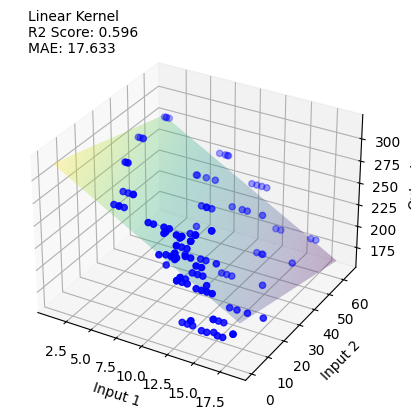

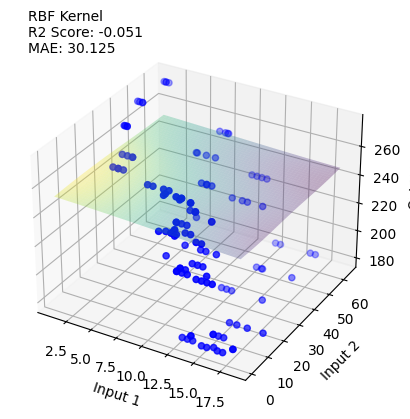

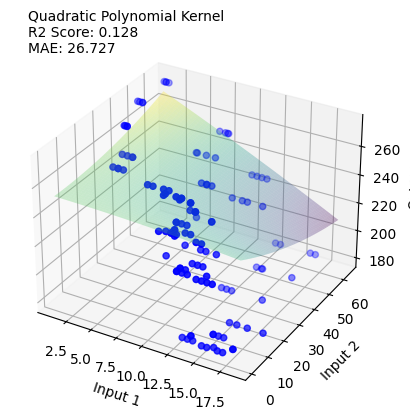

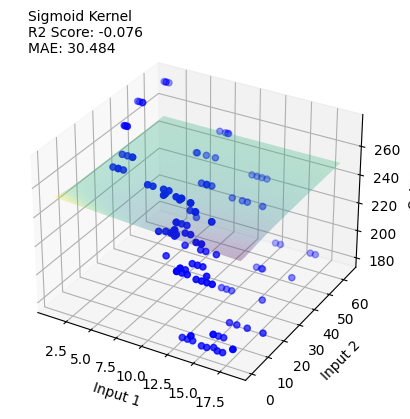

In [64]:
# create a list of regression models to evaluate
regressors = [
    ('Linear Kernel', SVR(kernel='linear')),
    ('RBF Kernel', SVR(kernel='rbf')),
    ('Quadratic Polynomial Kernel', SVR(kernel='poly', degree=2)),
    ('Sigmoid Kernel', SVR(kernel='sigmoid')),
]

# set up the KFold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# loop over the regression models
for name, regressor in regressors:
    # initialize the arrays to hold the predicted and actual values
    y_pred = np.zeros_like(y)
    y_true = np.zeros_like(y)
    
    # loop over the folds in the cross-validation
    for train_idx, test_idx in kf.split(X, y):
        # split the data into training and testing sets
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # train the model on the training data
        regressor.fit(X_train, y_train)
        
        # predict the output values for the testing data
        y_pred[test_idx] = regressor.predict(X_test)
        y_true[test_idx] = y_test
    
    # calculate the evaluation metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    # create a meshgrid for the input variables
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
    
    # predict the output values for the meshgrid input
    zz = regressor.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    

    # set up the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot the data points
    ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o')

    # set the labels for the plot
    ax.set_xlabel('Input 1')
    ax.set_ylabel('Input 2')
    ax.set_zlabel('Output')

    # plot the fitted surface for the regression model
    ax.plot_surface(xx, yy, zz, alpha=0.3, cmap='viridis', label=name)
    
# add the evaluation metrics to the plot
    ax.text2D(0.05, 0.95, f"{name}\nR2 Score: {r2:.3f}\nMAE: {mae:.3f}", transform=ax.transAxes)
    
    # show the plot
    plt.show()

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Set alpha values
alpha_values = [1, 2]

# Loop through alpha values
for alpha in alpha_values:

    # Define L2-regularized regression models
    lin_reg_l2 = SVR(kernel="linear", C=1/alpha)
    rbf_reg_l2 = SVR(kernel="rbf", C=1/alpha)
    poly_reg_l2 =  SVR(kernel="poly", degree=2, C=1/alpha)
    sigmoid_reg_l2 = SVR(kernel="sigmoid", C=1/alpha)

    # Define K-Fold cross-validation with k=4
    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Initialize arrays to store performance metrics
    mae = np.zeros((4, 4))
    r2 = np.zeros((4, 4))

    # Loop through regression models and cross-validation folds
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):

        # Split data into training and testing sets
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Fit regression models on training data
        lin_reg_l2.fit(X_train, y_train)
        rbf_reg_l2.fit(X_train, y_train)
        poly_reg_l2.fit(X_train, y_train)
        sigmoid_reg_l2.fit(X_train, y_train)

        # Make predictions on testing data
        lin_y_pred_l2 = lin_reg_l2.predict(X_test)
        rbf_y_pred_l2 = rbf_reg_l2.predict(X_test)
        poly_y_pred_l2 = poly_reg_l2.predict(X_test)
        sigmoid_y_pred_l2 = sigmoid_reg_l2.predict(X_test)

        # Calculate performance metrics
        mae[i, 0] = mean_absolute_error(y_test, lin_y_pred_l2)
        mae[i, 1] = mean_absolute_error(y_test, rbf_y_pred_l2)
        mae[i, 2] = mean_absolute_error(y_test, poly_y_pred_l2)
        mae[i, 3] = mean_absolute_error(y_test, sigmoid_y_pred_l2)

        r2[i, 0] = r2_score(y_test, lin_y_pred_l2)
        r2[i, 1] = r2_score(y_test, rbf_y_pred_l2)
        r2[i, 2] = r2_score(y_test, poly_y_pred_l2)
        r2[i, 3] = r2_score(y_test, sigmoid_y_pred_l2)
    print('alpha=',alpha,'\n mae=',mae.mean(axis=0), '\n r2=',r2.mean(axis=0))

alpha= 1 
 mae= [17.59616982 30.14489009 26.71411126 30.47890763] 
 r2= [ 0.59445997 -0.06796805  0.12404027 -0.0924462 ]
alpha= 2 
 mae= [17.43738893 30.46358743 28.90986174 30.62705785] 
 r2= [ 0.59390167 -0.09651513 -0.0092598  -0.10835159]


In [70]:
# create a list of regression models to evaluate
regressors = [
    ('Linear Kernel', SVR(kernel='linear')),
    ('Quadratic Polynomial Kernel', SVR(kernel='poly', degree=2)),
    ('Third degree polynomial Kernel', SVR(kernel='poly', degree=3)),
    ('Fourth degree polynomial Kernel', SVR(kernel='poly', degree=4)),
    ('RBF Kernel', SVR(kernel='rbf')),
]
for name, regressor in regressors:
    # initialize the arrays to hold the predicted and actual values
    y_pred = np.zeros_like(y)
    y_true = np.zeros_like(y)

    # loop over the regularization parameters
    for C in [300, 50, 20, 10, 5,1, 0.8, 0.2]:
        regressor.C = C  # set the regularization parameter

        # loop over the folds in the cross-validation
        for train_idx, test_idx in kf.split(X, y):
            # split the data into training and testing sets
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            # train the model on the training data
            regressor.fit(X_train, y_train)

            # predict the output values for the testing data
            y_pred[test_idx] = regressor.predict(X_test)
            y_true[test_idx] = y_test

        # calculate the evaluation metric (R2 score)
        r2 = r2_score(y_true, y_pred)

        # print the R2 score for the current combination of kernel function and regularization parameter
        print(f"{name}, C={C}, R2 score: {r2:.3f}")

Linear Kernel, C=300, R2 score: 0.596
Linear Kernel, C=50, R2 score: 0.597
Linear Kernel, C=20, R2 score: 0.597
Linear Kernel, C=10, R2 score: 0.597
Linear Kernel, C=5, R2 score: 0.597
Linear Kernel, C=1, R2 score: 0.596
Linear Kernel, C=0.8, R2 score: 0.596
Linear Kernel, C=0.2, R2 score: 0.588
Quadratic Polynomial Kernel, C=300, R2 score: 0.617
Quadratic Polynomial Kernel, C=50, R2 score: 0.594
Quadratic Polynomial Kernel, C=20, R2 score: 0.547
Quadratic Polynomial Kernel, C=10, R2 score: 0.433
Quadratic Polynomial Kernel, C=5, R2 score: 0.344
Quadratic Polynomial Kernel, C=1, R2 score: 0.128
Quadratic Polynomial Kernel, C=0.8, R2 score: 0.083
Quadratic Polynomial Kernel, C=0.2, R2 score: -0.040
Third degree polynomial Kernel, C=300, R2 score: 0.590
Third degree polynomial Kernel, C=50, R2 score: 0.536
Third degree polynomial Kernel, C=20, R2 score: 0.447
Third degree polynomial Kernel, C=10, R2 score: 0.349
Third degree polynomial Kernel, C=5, R2 score: 0.272
Third degree polynomial